# Import data and libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

import scripts

# constants and settings
rand_seed = 35

In [10]:
# Load the data
tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())

In [11]:
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(f"Dataset shape: {tree_data.shape}")

Nan values in dataset: 0
Dataset shape: (581012, 55)


# Data exploration

In [12]:
tree_reduced = scripts.sample_stratify(tree_data, 'Cover_Type', n_samples=2000, rand_state=rand_seed)
X_tree, y_tree = tree_reduced.drop(columns=['Cover_Type']), tree_reduced['Cover_Type']
y_tree -= 1  # make labels zero-indexed


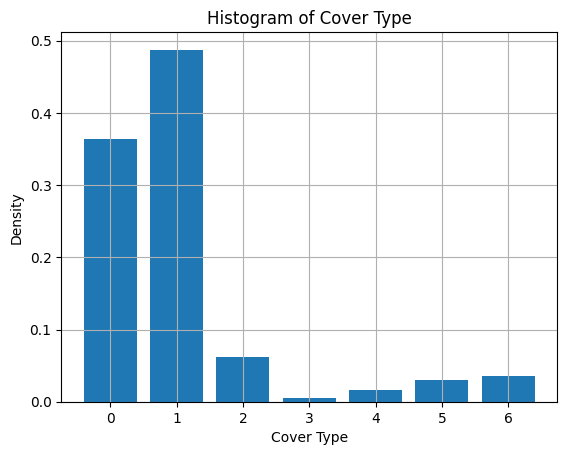

(2000, 54)

In [13]:
scripts.plot_histogram(y_tree, label='Cover Type')
X_tree.shape

Very uneven label distribution, mostly centered on types 1 and 2.
Stratified sampling require to ensure labels 3-7 are properly represented in training.

In [14]:
# std_scaler, x_st_scale = scripts.normalize_data(X_tree, method='standard')
scaler = preproc.StandardScaler()
x_st_scale = scaler.fit_transform(X_tree)

## Split training/testing data

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_st_scale, y_tree, test_size=0.2, stratify=y_tree, random_state=rand_seed)


In [16]:
# Oversample
x_oversample, y_oversample = SMOTE(random_state=rand_seed, sampling_strategy="auto", k_neighbors=2).fit_resample(x_train, y_train)
x_train, x_val, y_train, y_val = train_test_split(x_oversample, y_oversample, test_size=0.2, stratify=y_oversample, random_state=rand_seed)

# scripts.plot_histogram(y_oversample, label='Cover Type after Oversampling')

# Perceptron model training

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

drop_fraction = 0.2
model = Sequential([
    InputLayer(input_shape=(54,)),
    Dense(128, activation='relu'),
    Dropout(drop_fraction),
    Dense(64, activation='relu'),
    Dropout(drop_fraction),
    Dense(32, activation='relu'),
    Dropout(drop_fraction),
    Dense(7, activation='softmax')
])

/home/alyx/Classes/CSCI635/CSCI-635-1-Group-5/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-10-20 16:10:26.466170: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,607 (68.78 KB)

 Trainable params: 17,607 (68.78 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=200,
                    batch_size=1024,
                    callbacks=[es],
                    verbose=1)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7985 - loss: 0.4956 - val_accuracy: 0.8370 - val_loss: 0.4266
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7992 - loss: 0.4898 - val_accuracy: 0.8397 - val_loss: 0.4265
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8059 - loss: 0.4779 - val_accuracy: 0.8407 - val_loss: 0.4263
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8006 - loss: 0.4833 - val_accuracy: 0.8416 - val_loss: 0.4262
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7985 - loss: 0.4925 - val_accuracy: 0.8416 - val_loss: 0.4258
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8008 - loss: 0.4855 - val_accuracy: 0.8416 - val_loss: 0.4256
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7944 - loss: 0.4929 - val_accuracy: 0.8416 - val_loss: 0.4255
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8088 - loss: 0.4902 - val_accuracy: 0.8416 - val_loss: